# Sieci konwolucyjne

Zadanie dla Państwa na te ćwiczenia to implementacja funkcji konwolucji oraz max pooling dla obrazów.

In [1]:
# ploting
%matplotlib inline
# imports
import torch
import numpy as np
import matplotlib.pyplot as plt
from itertools import product

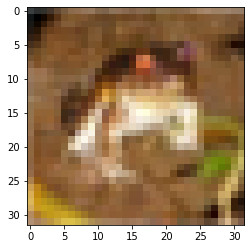

In [2]:
# data loading
cifar_sample = np.load('./resources/cifar_sample.npy')
# get a first random image
np_image = cifar_sample[0]
# this should plot a blurry frog
plt.imshow(np_image.transpose(1,2,0)) 

### Wzory na rozmiary
**Pytanie 1**: Jaki będzie rozmiar obrazka na wyjściu konwolucji/poolingu przy parametrach poniżej.  
**Uwaga**: zarówno we wzorach jak i w kodzie używana jest torchowa konwencja *channel first*.

Stride: $ \hspace{95px} S $  
Padding: $ \hspace{80px} P $  
Obrazek wejściowy: $ \hspace{12px} C_i \times H_i \times W_i$  
Filtry: $ \hspace{100px} K \times C_f \times F \times F $  

Gdzie: $C_i$ to liczba kanału obrazu wejściowego, $H_i, W_i$ to odpowiednio wysokość i szerokość obrazu wejściowego. $K$ to liczba filtrów, $C_f$ liczba kanałów w każdym filtrze, $F$ to zarówno wysokość jak i szerokość filtra (rozważamy tylko filtry kwadratowe).

Obrazek wyjściowy: $ \hspace{15px} C_o \times H_o \times W_o $  


$ \hspace{140px} C_o = \text{???} $  

$ \hspace{140px} H_o = \text{???} $  

$ \hspace{140px} W_o = \text{???} $  

**Pytanie 2**: Ile wag (floatów) ma taka warstwa konwolucyja?   


### Wizualna pomoc do konwolucji
[Źródło](http://cs231n.github.io/convolutional-networks/)

<img src="./resources/cnn.gif"></img>

### Zadanie 1:  Konwolucja (5 pkt.)
Zadaniem jest zaimplementowanie funkcji konwolucji i poolingu dla obrazka 2D. Implementacja nie musi być optymalna pod względem złożoności czasowej (tzn. można/zaleca się używać pętli). 

Warunkiem zaliczenia zadania jest przejście komórek testowych dla konwolucji i poolingu. W razie problemów polecam zacząć od poolingu, który jest podobny do konwolucji, ale mniej skomplikowany.

In [20]:
from torch.nn.functional import pad as pad

def convolution(image: torch.tensor, 
                filters: torch.tensor, 
                bias: torch.tensor, 
                stride: int = 1, 
                padding: int = 1):
    """
    :param image: torch.Tensor 
        Input image of shape (C, H, W)
    :param filters: torch.Tensor 
        Filters to use in convolution of shape (K, C, F, F)
    :param bias: torch.Tensor 
        Bias vector of shape (K,)
    :param stride: int
        Stride to use in convolution
    :param padding: int
       Zero-padding to add on all sides of the image 
    """
    print('image')
    print(image)
    print('filters')
    print(filters)
    print('bias')
    print(bias)
    print('padding')
    print(padding)
    print('stride')
    print(stride)
    # get image dimensions
    # torch.Size([3, 32, 32])
    img_channels, img_height, img_width = image.shape 
    # torch.Size([2, 3, 3, 3])
    n_filters, filter_channels, filter_size, filter_size = filters.shape 
    # calculate the dimensions of the output image
    out_height = int(((img_height - filter_size + 2 * padding) / stride) + 1)
    out_width = int(((img_width - filter_size + 2 * padding) / stride) + 1)
    out_channels = n_filters
    image_orig = image
    
    image_padded = pad(image_orig[0], (1,1,1,1), mode='constant')
    print('image_padded')
    print(image_padded)
    print('image_padded - shape')
    print(image_padded.shape)
    
    # image_padded[padding+image_orig.shape[0],padding + image_orig.shape[1]] = image_orig
    res = []
    for x in range(0, n_filters):
        for i in range(0,out_height):
            res.append([])
            for j in range(0,out_width):
                    convolve = image_padded[i:i + filters[x,:,:,:], j:j + filters[x,:,:,:]]
                    res[-1].append(torch.sum(convolve * filters[x,:,:,:]))
    return torch.tensor(res)
    


In [21]:
# Convolution Test

# cast the frog to tensor
image = torch.tensor(np_image)
# preapre parameters for testing
paddings = [0, 1, 2, 3]
strides = [1, 2, 3, 4]
filters = [(torch.randn((2,3,3,3)), torch.randn((2))),
           (torch.randn((2,3,5,5)), torch.randn((2))),
           (torch.randn((5,3,1,1)), torch.randn((5)))]

# test all combinations
for (filt, bias), stride, padding in product(filters, strides, paddings):
    # your convolution
    out = convolution(image, filt, bias, stride=stride, padding=padding)
    # PyTorch equivalent
    out_torch = torch.conv2d(input=image.unsqueeze(0), weight=filt, bias=bias, padding=padding, stride=stride)
    # asserts
    assert out_torch.squeeze().shape == out.shape
    assert torch.allclose(out, out_torch.squeeze(), atol=1e-5, rtol=1e-5)

image
tensor([[[0.2314, 0.1686, 0.1961,  ..., 0.6196, 0.5961, 0.5804],
         [0.0627, 0.0000, 0.0706,  ..., 0.4824, 0.4667, 0.4784],
         [0.0980, 0.0627, 0.1922,  ..., 0.4627, 0.4706, 0.4275],
         ...,
         [0.8157, 0.7882, 0.7765,  ..., 0.6275, 0.2196, 0.2078],
         [0.7059, 0.6784, 0.7294,  ..., 0.7216, 0.3804, 0.3255],
         [0.6941, 0.6588, 0.7020,  ..., 0.8471, 0.5922, 0.4824]],

        [[0.2431, 0.1804, 0.1882,  ..., 0.5176, 0.4902, 0.4863],
         [0.0784, 0.0000, 0.0314,  ..., 0.3451, 0.3255, 0.3412],
         [0.0941, 0.0275, 0.1059,  ..., 0.3294, 0.3294, 0.2863],
         ...,
         [0.6667, 0.6000, 0.6314,  ..., 0.5216, 0.1216, 0.1333],
         [0.5451, 0.4824, 0.5647,  ..., 0.5804, 0.2431, 0.2078],
         [0.5647, 0.5059, 0.5569,  ..., 0.7216, 0.4627, 0.3608]],

        [[0.2471, 0.1765, 0.1686,  ..., 0.4235, 0.4000, 0.4039],
         [0.0784, 0.0000, 0.0000,  ..., 0.2157, 0.1961, 0.2235],
         [0.0824, 0.0000, 0.0314,  ..., 0.1961, 0.19

TypeError: only integer tensors of a single element can be converted to an index

### Zadanie 2. Max Pooling (2 pkt.)
Operacja *max pooling* jest analogiczna do zwykłej konwolucji, lecz zamiast operacji mnożenia z zadanym filtrem na każdym fragmencie wejścia wykonywana jest funkcja *max*.

In [5]:
def max_pooling(image: torch.tensor, 
                kernel_size: int, 
                stride: int = 1, 
                padding: int = 1):
    """
    :param image: torch.Tensor 
        Input image of shape (C, H, W)
    :param kernel_size: int 
        Size of the square pooling kernel
    :param stride: int
        Stride to use in pooling
    :param padding: int
       Zero-padding to add on all sides of the image 
    """
    # get image dimensions
    img_channels, img_height, img_width = image.shape
    # calculate the dimensions of the output image
    out_height = ???
    out_width = ???
    out_channels = ???

    # your code here

    return ???

In [6]:
# Max Pooling Test
from itertools import product

# cast the frog to tensor
image = torch.tensor(np_image)
# preapre parameters for testing
kernel_sizes = [2, 3, 4]
paddings = [0, 1]
strides = [1, 2, 3, 4]

# test all combinations
for kernel_size, stride, padding in product(kernel_sizes, strides, paddings):
    # your pooling
    out = max_pooling(image, kernel_size=kernel_size, stride=stride, padding=padding)
    # PyTorch equivalent
    out_torch = torch.nn.functional.max_pool2d(input=image.unsqueeze(0), kernel_size=kernel_size, padding=padding, stride=stride)
    # asserts
    assert out_torch.squeeze().shape == out.shape
    assert torch.allclose(out, out_torch.squeeze(), atol=1e-5, rtol=1e-5)